# Projet 7 - Réalisez des indexations automatiques d'images

https://docs.opencv.org/3.4.3/d6/d00/tutorial_py_root.html

## Initialisation

#### drive Google

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Librairies

In [0]:
import os
# Import the `pandas` library as `pd`
import pandas as pd
# Import the `numpy` library as `np`
import numpy as np
# import OpenCV library as cv2
import cv2 as cv2

import gc

import seaborn as sns
sns.set()

# Import patch for image show of OpenCV
from google.colab.patches import cv2_imshow
# Import pyplot from matplotlib as plt
from matplotlib import pyplot as plt
# Import joblib functions for save and load
from joblib import dump, load
# Librairie Scikit-Learn
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split


from shutil import copy

from time import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.utils.multiclass import unique_labels

In [0]:
import shutil

In [0]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
  
import h5py

#### Contexte de mémoire

In [0]:
# cache directory for joblib objects
folder = "/content/gdrive/My Drive/Colab Notebooks/P7 - Classif chiens/joblib_memmap"

# str_dir_gray = "/content/gdrive/My Drive/Colab Notebooks/P7 - Classif chiens/preprocess/step_to_gray/"
# str_dir_blur = "/content/gdrive/My Drive/Colab Notebooks/P7 - Classif chiens/preprocess/step_to_blur/"
# str_dir_size = "/content/gdrive/My Drive/Colab Notebooks/P7 - Classif chiens/preprocess/step_to_size/"
# str_dir_raw = "/content/gdrive/My Drive/Colab Notebooks/P7 - Classif chiens/raw/"
str_dir_preprocessed = "/content/gdrive/My Drive/Colab Notebooks/P7 - Classif chiens/preprocessed/"
folders = [
#     folder,
#            str_dir_gray,
#            str_dir_blur,
#            str_dir_size,
#            str_dir_raw,
           str_dir_preprocessed
          ]

In [0]:
def init_mem():
  for fold in folders:
    shutil.rmtree(fold, ignore_errors=True, onerror=None)
    try:      
      os.mkdir(fold)
    except FileExistsError:
        pass

## Exploration

In [0]:
str_directory = "/content/gdrive/My Drive/Colab Notebooks/P7 - Classif chiens/base/Images/"
dirs = sorted(os.listdir(str_directory))
print("il y a {} races à classifier.".format(len(dirs)))

il y a 120 races à classifier.


In [0]:
target_names = []
for dir in dirs: 
  ref, name = (dir.split('-', 1 ))
  target_names.append(name)
#   print(ref, name)

In [0]:
# cache directory for joblib objects
folder = "/content/gdrive/My Drive/Colab Notebooks/P7 - Classif chiens/joblib_memmap"
try:
    os.mkdir(folder)
except FileExistsError:
    pass

In [0]:
data_filename_memmap = os.path.join(folder, 'target')
dump(target_names, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P7 - Classif chiens/joblib_memmap/target']

#### Train_test split

In [0]:
def train_test_function(nb_races):
  # on construit liste fichiers et classe correspondante dans deux listes:
  X = []
  y = []

  for dir in dirs[:nb_races]:
    dir_path = str_directory + dir + '/'
    for file in sorted(os.listdir(dir_path)):
      X.append(dir_path + file)
      y.append(file.split('_')[0])  

#   n_classes = len(y)
#   print("il y a {} classes".format(n_classes))
  target_names = list(unique_labels(y))
  y = [target_names.index(x) for x in y]
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train,
                                                                    test_size=0.25,
                                                                    random_state=0)
  
  # plot with various axes scales
  plt.figure(figsize=(18, 7))

  # y
  plt.subplot(231)
  plt.hist(y, bins=nb_races)
  plt.title('global')
  
  # train
  plt.subplot(232)
  plt.hist(y_train, bins=nb_races)
  plt.title('train')
  
  # test
  plt.subplot(233)
  plt.hist(y_test, bins=nb_races)
  plt.title('test')

  # train CNN
  plt.subplot(235)
  plt.hist(y_train_cnn, bins=nb_races)
  plt.title('train CNN')
  
  # val CNN
  plt.subplot(236)
  plt.hist(y_val_cnn, bins=nb_races)
  plt.title('validation CNN')

  plt.show()
  
  return X_train, X_test, y_train, y_test, X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn, target_names

### resizing

In [0]:
def copy_raw_images(nb_races):
  """ Copie des images d'origine dans un répertoire de départ
  
  nb_races: nombre de races (répertoires) utilisés
  
  renvoie: None
  """
  for dir in dirs[:nb_races]:
    dir_path = str_directory + dir + '/'
    for file in sorted(os.listdir(dir_path)):
      copy(src = dir_path + file, dst = str_dir_raw)
      
def conv_to_gray(img):
  """ Conversion de l'image couleur -> niveaux de gris
  
  img: image à traiter
  
  renvoie: une image en niveaux de gris
  """
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return gray

def conv_resize(img):
  """ Redimensionnement de l'image
  
  img: image à traiter
  
  renvoie: une image aux dimensions standardisées
  """
  standard_size = (500, 375)
  return cv2.resize(img, standard_size)

def conv_blur(img, filter_size=1):
  """ Filtre gaussien
  
  img: image à traiter
  filter_size: taille du filtre (doit être un entier impair)
  
  renvoie: une image   
  """
  return cv2.GaussianBlur(img,     # image à traiter
                          ksize=(filter_size,filter_size),    # Gaussian kernel size
                          sigmaX=0)

In [0]:
def preprocess_fct(X, filt_size):
  """ fonction de préprocessing
  filt_sizes: taille du filtre gaussien
  
  renvoie: None
  """
  for file in X:    
    img = cv2.imread(file)

    gray_img = conv_to_gray(img)
    resize_img = conv_resize(gray_img)
    blur_img = conv_blur(resize_img, filt_size)

    cv2.imwrite(str_dir_preprocessed + file.split('/')[-1], blur_img)
  

## Méthode 1: apprentissage supervisé
https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5072281-utilisez-ces-features-pour-classifier-des-images



### 1.Extraction des features - méthode ORB
détection et description des features
https://docs.opencv.org/3.4.3/d1/d89/tutorial_py_orb.html
http://www.willowgarage.com/sites/default/files/orb_final.pdf

basé sur le détecteur de point-clés FAST et le descripteur BRIEF


In [0]:
# # files = sorted(os.listdir(str_dir_blur))
# for file in X_train[:5]:
#   img = cv2.imread(str_dir_preprocessed + file,0)

#   # Initiate ORB detector
#   orb = cv2.ORB_create()
#   # find the keypoints with ORB
#   kp = orb.detect(img,None)
#   # compute the descriptors with ORB
#   kp, des = orb.compute(img, kp)
#   # draw only keypoints location,not size and orientation
#   img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
#   plt.figure(figsize=(10,6))
#   plt.imshow(img2)
#   plt.show()

### Feature matching
Brute-Force Matcher

In [0]:
# for i in range(5):
#   img1 = cv2.imread(str_dir_preprocessed + X_train[i],0)
#   img2 = cv2.imread(str_dir_preprocessed + X_train[i+1],0)

#   # find the keypoints and descriptors with ORB
#   kp1, des1 = orb.detectAndCompute(img1,None)
#   kp2, des2 = orb.detectAndCompute(img2,None)

#   # create BFMatcher object
#   bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
#   # Match descriptors.
#   matches = bf.match(des1,des2)
#   # Sort them in the order of their distance.
#   matches = sorted(matches, key = lambda x:x.distance)
#   # Draw first 10 matches.
#   img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20], None,flags=0)
#   plt.figure(figsize=(12,10))
#   plt.imshow(img3),plt.show()

FLANN based Matcher

In [0]:
# # FLANN parameters
# FLANN_INDEX_LSH = 6
# index_params= dict(algorithm = FLANN_INDEX_LSH,
#                    table_number = 6, # 12
#                    key_size = 12,     # 20
#                    multi_probe_level = 1) #2

# search_params = dict(checks=50)   # or pass empty dictionary
# flann = cv2.FlannBasedMatcher(index_params,search_params)

# for i in range(5):
#   img1 = cv2.imread(str_dir_preprocessed + X_train[i],0)
#   img2 = cv2.imread(str_dir_preprocessed + X_train[i+1],0)

#   # find the keypoints and descriptors with ORB
#   kp1, des1 = orb.detectAndCompute(img1,None)
#   kp2, des2 = orb.detectAndCompute(img2,None)
#   matches = flann.knnMatch(des1,des2,k=2)
#   # Need to draw only good matches, so create a mask
#   matchesMask = [[0,0] for i in range(len(matches))]
#   # ratio test as per Lowe's paper
#   try:
#     for i,(m,n) in enumerate(matches):
# #       print(i, m.distance, n.distance)
#       if m.distance < 0.7*n.distance:
#         matchesMask[i]=[1,0]
#   except:
#     continue
    
#   draw_params = dict(matchColor = (0,255,0),
#                      singlePointColor = (255,0,0),
#                      matchesMask = matchesMask,
#                      flags = 0)
#   img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
#   plt.figure(figsize=(12,10))
#   plt.imshow(img3,),plt.show()

### 2.Création des bag-of-features
vecteur créé en deux temps : d'abord, on crée les "visual words", puis on construit un histogramme. 
#### Création des visual words
Pour créer le "dictionnaire" de visual words, il suffit d'appliquer un algorithme de clustering aux descripteurs de features construits à l'étape 1, comme le k-means. Les visual words correspondent alors aux centres des clusters trouvés.


In [0]:
def create_dict(X, dictionarySize = 50):
  """ Fonction qui créée le dictionnaire de visual words
  
  renvoie: dictionnaire
  """
  # Initiate ORB detector
  orb = cv2.ORB_create()
  # Initiate BOW K Means Trainer
  bow = cv2.BOWKMeansTrainer(dictionarySize)

  # files = sorted(os.listdir(str_dir_blur))
  for file in X:
    img = cv2.imread(str_dir_preprocessed + file.split('/')[-1],0)

    # find the keypoints and compute the descriptors with ORB
    kp, des  = orb.detectAndCompute(img,None)

    bow.add(np.float32(des))

  #dictionary created
  dictionary = bow.cluster()
  
  return dictionary

#### Construction de l'histogramme
Il reste à décrire les images en fonction de ces visual words. Pour chaque image, on crée un histogramme qui indique la fréquence d'apparition de chaque visual word dans l'image

Finalement, le bag-of-features d'une image est le vecteur dans lequel on a stocké les valeurs de l'histogramme et qu'on a normalisé (en divisant par la norme euclidienne). 



In [0]:

# orb2 = cv2.ORB_create()
# # orb2 = cv2.ORB_create(nfeatures=50)

# fbm_index_params = dict(algorithm = FLANN_INDEX_LSH,
#                    table_number = 12,
#                    key_size = 20,
#                    multi_probe_level = 2)

# fbm_search_params = dict(checks=50)

# fbm_matcher = cv2.FlannBasedMatcher(fbm_index_params,
#                                     fbm_search_params
#                                    )
# # fbm_matcher = cv2.FlannBasedMatcher(cv2.NORM_HAMMING
# #                                    )

# bowDiction = cv2.BOWImgDescriptorExtractor(orb2, fbm_matcher)

# bowDiction.setVocabulary(dictionary)
# print("bow dictionary", np.shape(dictionary))

On observe ce que donne le tracé d'histogramme pour quelques images.

In [0]:

# neigh = NearestNeighbors(n_neighbors=1)
# neigh.fit(dictionary)

# for file in X_train[:5]:
#   img = cv2.imread(str_dir_preprocessed + file)
#   # find the keypoints and compute the descriptors with ORB
#   kp, des  = orb2.detectAndCompute(img,None)
# #   des = np.float32(des)
#   resultat = neigh.kneighbors(des, return_distance=False)
#   # On trace la distributions des dimensions d'images
#   plt.figure(figsize=(12,4))
#   plt.subplot(121)
#   plt.axis('off')
#   plt.grid(b=None)
#   plt.imshow(img),plt.title(file)
#   plt.subplot(122)
#   plt.hist(resultat, bins=50)
# #   plt.title('bow')

#   plt.show()
  
#   resultat = resultat.flatten()

In [0]:
def count_bovw(histo, dictionarySize):
  X_count = [0] * dictionarySize
  for i in histo:
    X_count[i] += 1
  return X_count

In [0]:
def hist_build(knn_model, X, orb, dict_size):
  """
  Fonction qui créée l'histogramme de chaque image
  
  renvoie: le bag of words des images
  """

  X_count = []

  for item in X:
    img = cv2.imread(str_dir_preprocessed + item.split('/')[-1])
    # find the keypoints and compute the descriptors with ORB
    kp, des  = orb.detectAndCompute(img,None)
    hist = knn_model.kneighbors(des, return_distance=False)

    X_count.append(count_bovw(hist.flatten(), dict_size))
  return X_count

### 3.Classification supervisée
on va entraîner un algorithme d'apprentissage supervisé sur les bag-of-features construits à l'étape 2.
Les algorithmes que l'on peut utiliser ont déjà été expliqués en détails dans d'autres cours. Si vous n'êtes pas familiers avec les techniques d'apprentissage supervisé, je vous encourage très fortement à lire les chapitres suivants, classés dans l'ordre croissant de difficulté :
* k plus proches voisins (k-NN) (https://openclassrooms.com/courses/initiez-vous-au-machine-learning/tp-entrainez-le-modele-des-k-plus-proches-voisins-k-nn)
* Régression logistique(https://openclassrooms.com/courses/entrainez-un-modele-predictif-lineaire/predisez-lineairement-la-probabilite-de-lappartenance-dun-point-a-une-classe)
* SVM (2 classes)(https://openclassrooms.com/courses/entrainez-un-modele-predictif-lineaire/maximisez-la-marge-de-separation-entre-vos-classes)
* SVM (multi-classes)(https://openclassrooms.com/courses/entrainez-un-modele-predictif-lineaire/classifiez-vos-donnees-en-plus-de-deux-classes)
* SVM à noyau(https://openclassrooms.com/courses/utilisez-des-modeles-supervises-non-lineaires/classifiez-vos-donnees-avec-une-svm-a-noyau)



#### Construction des features

In [0]:
# from sklearn.feature_extraction.text import CountVectorizer

In [0]:
# # Initialize the "CountVectorizer" object
# vectorizer = CountVectorizer(analyzer = "word",
#                              tokenizer = None,
#                              preprocessor = None,
#                              stop_words = None,
#                              max_df = 0.5,
#                              max_features = 1000
#                             ) 

In [0]:
# # fit_transform() does two functions: First, it fits the model
# # and learns the vocabulary; second, it transforms our training data
# # into feature vectors. The input to fit_transform should be a list of 
# # strings.
# X_train_count = vectorizer.fit_transform(X_train)

In [0]:
# # Numpy arrays are easy to work with, so convert the result to an array
# X_train_count = X_train_count.toarray()

In [0]:
# X_test_count = vectorizer.transform(X_test)

In [0]:
# X_test_doclen = X_test_count.toarray()

In [0]:

# for file in X_train:
#   img = cv2.imread(str_dir_preprocessed + file)

#   # find the keypoints and compute the descriptors with ORB
#   kp_bow  = orb2.detect(img,None)
#   des_bow = orb2.compute(img,kp_bow)
#   print(des_bow)
  
#   bowDiction.compute(img, kp_bow, des_bow, )
  
# print(des_bow)
# print(np.shape(des_bow))
# #   bow.add(np.float32(des))

In [0]:
# bowDiction

#### Entrainement du modèle

In [0]:
def model_fct(X_train_count, y_train, param_grid):
  clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'),
                     param_grid, cv=5, iid=False)
  clf = clf.fit(X_train_count, y_train)
  return clf

#### Prédiction et mesure de performance

In [0]:
def pred_perf(clf, X_test_count, y_test, target_names):
  ''' Quantitative evaluation of the model quality on the test set
  ''' 
  print("Prédiction des races de chien sur le jeu de test")
  y_pred = clf.predict(X_test_count)

  print("Accuracy: {:2.1f} %.".format(100*accuracy_score(np.array(y_test), y_pred)))

  print(classification_report(y_test, y_pred, target_names=target_names))
  
  return y_pred

#### Matrice de confusion

In [0]:

# print(confusion_matrix(np.array(y_test), y_pred, labels=range(len(target_names[:3]))))

In [0]:
# def conf_mat(y_test, y_pred):
#   conf_mat = confusion_matrix(np.array(y_test), y_pred)
#   norm_conf = []
#   for i in conf_mat:
#       a = 0
#       tmp_arr = []
#       a = sum(i, 0)
#       for j in i:
#           tmp_arr.append(float(j)/float(a))
#       norm_conf.append(tmp_arr)

#   fig = plt.figure()
#   plt.clf()
#   ax = fig.add_subplot(111)
#   ax.set_aspect(1)
#   res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
#                   interpolation='nearest')

#   width, height = conf_mat.shape

#   for x in xrange(width):
#       for y in xrange(height):
#         pass

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = unique_labels(y_true, y_pred)
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### CNN

In [0]:
def init_cnn(nb, img_size):
  """
  This function defines the CNN model coorespondingg to VGG16 and nb_races classes to predict
  returns model"""
    # Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
  base_model = VGG16(weights="imagenet",
                     include_top=False,
                     input_shape=img_size)
  
  add_model = Sequential()
  add_model.add(Flatten(input_shape=base_model.output_shape[1:]))

  if nb < 20:
    add_model.add(Dense(128, activation='relu'))
    add_model.add(Dense(64, activation='relu'))
  else: 
    add_model.add(Dense(256, activation='relu'))
    add_model.add(Dense(128, activation='relu'))

  add_model.add(Dense(nb, activation='softmax'))

  model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
  model.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.SGD(lr=5e-5, momentum=0.9),
                metrics=['categorical_accuracy'])

  return model

In [0]:
def cnn_features(X, y, img_size):
  X_feat = []
  
  for file in X:
    img = cv2.imread(file)
  
    X_feat.append(cv2.resize(img, img_size))
  
  X_feat = np.array(X_feat)
  X_feat = X_feat.astype('float32')
  X_feat /= 255

  y_feat = OneHotEncoder(handle_unknown='ignore').fit_transform(np.asarray(y).reshape(-1, 1)).toarray()
  y_feat = np.array(y_feat)
  
  return X_feat, y_feat

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
def train_cnn(model, X_train, X_val, y_train, y_val, batch_size):
  epochs = 100

  train_datagen = ImageDataGenerator(rotation_range=30,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True)
  train_datagen.fit(X_train)


  history = model.fit_generator(train_datagen.flow(X_train,
                                                   y_train,
                                                   batch_size=batch_size),
                                steps_per_epoch=X_train.shape[0] // batch_size,
                                epochs=epochs,
                                validation_data=(X_val, y_val),
                                callbacks=[ModelCheckpoint('VGG16-transferlearning.model',
                                                           monitor='val_categorical_accuracy',
                                                           save_best_only=True),
#                                            EarlyStopping(monitor='val_categorical_accuracy',
#                                                          min_delta=0.001,
#                                                          patience=5,
#                                                          verbose=0,
#                                                          mode='auto',
#                                                          baseline=None,
#                                                          restore_best_weights=True)
                                          ]
                               )
  return history, model

In [0]:
def plot_hist(history):
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

60 races
Initialisation mémoires
Train/Test split


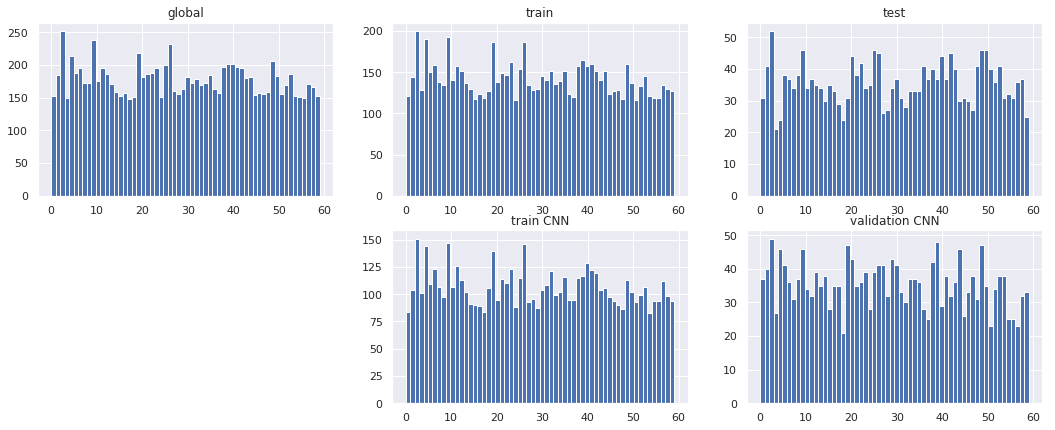


  CNN:
Epoch 1/100
49/49 [==============================] - 222s 5s/step - loss: 4.1816 - categorical_accuracy: 0.0204 - val_loss: 4.1121 - val_categorical_accuracy: 0.0211
Epoch 2/100
49/49 [==============================] - 172s 4s/step - loss: 4.0965 - categorical_accuracy: 0.0244 - val_loss: 4.0879 - val_categorical_accuracy: 0.0239
Epoch 3/100
49/49 [==============================] - 172s 4s/step - loss: 4.0810 - categorical_accuracy: 0.0268 - val_loss: 4.0784 - val_categorical_accuracy: 0.0300
Epoch 4/100
49/49 [==============================] - 172s 4s/step - loss: 4.0703 - categorical_accuracy: 0.0303 - val_loss: 4.0693 - val_categorical_accuracy: 0.0319
Epoch 5/100
49/49 [==============================] - 172s 4s/step - loss: 4.0628 - categorical_accuracy: 0.0339 - val_loss: 4.0604 - val_categorical_accuracy: 0.0338
Epoch 6/100
49/49 [==============================] - 172s 4s/step - loss: 4.0529 - categorical_accuracy: 0.0372 - val_loss: 4.0531 - val_categorical_accuracy: 0.0

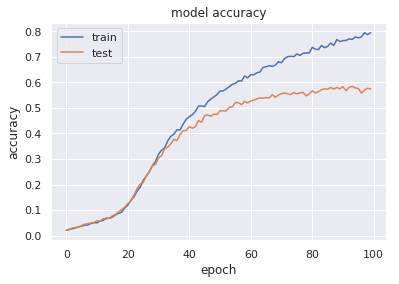

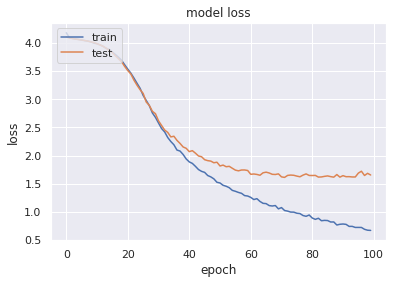

L'accuracy du CNN est de 58.61%
Normalized confusion matrix


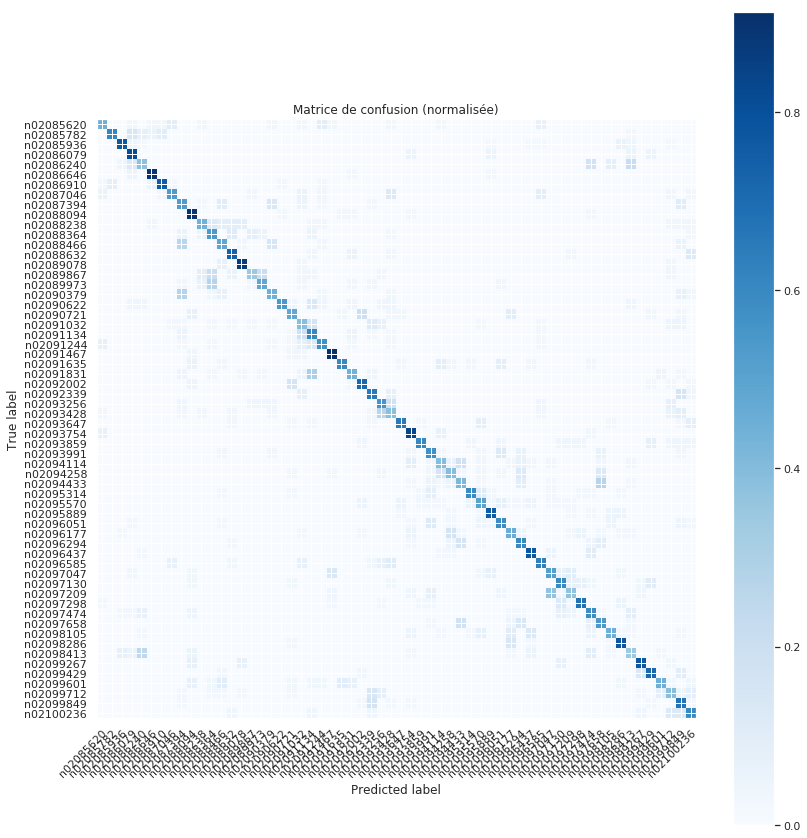

In [0]:
# nb_races = [3, 5, 10, 20, 40, 60]
nb_races = [60]

# hyperparamètres
filt_sizes = [1, 3, 5]
dict_sizes = [25, 50, 100]
param_grid = {'C': [1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }


for nb in nb_races:
  print("{} races".format(nb))
  
  if nb < 20:
    std_size=(500,375)
    std_size_cnn=(375,500,3)
    batch_size = 32
  else: 
    std_size=(240,180)
    std_size_cnn=(180,240,3)
    batch_size = 128
  
  print("Initialisation mémoires")
  init_mem()

  print(r"Train/Test split")
  X_train, X_test, y_train, y_test, X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn, target_names = train_test_function(nb)
  
  # Approche classique
  print("\n  Approche classique:")
  for filt_siz in filt_sizes:
    print("    filtre taille {}".format(filt_siz))
    print("      preprocess X_train")
    preprocess_fct(X_train, filt_siz)
    print("      preprocess X_test")
    preprocess_fct(X_test, filt_siz)
    for dict_size in dict_sizes:
      print("       creation dict. taille {}".format(dict_size))
      bow_dict = create_dict(X_train, dict_size)
      
      orb2 = cv2.ORB_create()
      
      neigh = NearestNeighbors(n_neighbors=1)      
      print("       entrainement knn")
      neigh.fit(bow_dict)
      
      
      print("       construction histo x_train")
      X_train_count = hist_build(neigh, X_train, orb2, dict_size)
      print("       construction histo x_test")
      X_test_count = hist_build(neigh, X_test, orb2, dict_size)
      
      print("       entrainement classifieur")
      classif = model_fct(X_train_count, y_train, param_grid)
      
      print("\n{} races, filtre de dimension {}, dictionnaire de taille {}.".format(nb, filt_siz, dict_size))
      print(classif.best_estimator_)
      
      y_pred = pred_perf(classif, X_test_count, y_test, target_names)
      
      # Plot normalized confusion matrix
      plot_confusion_matrix(y_test, y_pred, classes=target_names[:nb], normalize=True,
                      title='Matrice de confusion (normalisée)')

      plt.show()
  del X_train
  del X_train_count
  del X_test_count
  del y_train
  del y_pred
  del neigh
  del classif
  del orb2
  del bow_dict
  gc.collect()
      
  # CNN
  print("\n  CNN:")
  
  cnn_model = init_cnn(nb, std_size_cnn)
#   cnn_model.summary()
  
  X_train_cnn, y_train_cnn = cnn_features(X_train_cnn, y_train_cnn, std_size)
  X_val_cnn, y_val_cnn = cnn_features(X_val_cnn, y_val_cnn, std_size)
  X_test_cnn, y_test_cnn = cnn_features(X_test, y_test, std_size)
  
  hist, model = train_cnn(cnn_model, X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn, batch_size)
  plot_hist(hist)
  cnn_pred = model.predict(X_test_cnn)
  y_pred_cnn = cnn_pred.argmax(axis=-1)
  y_test_cnn = y_test_cnn.argmax(axis=-1)
  cnn_acc = accuracy_score(y_test_cnn, y_pred_cnn)
  print("L'accuracy du CNN est de %.2f%%" % (cnn_acc*100))
  
  plot_confusion_matrix(y_test_cnn, y_pred_cnn, classes=target_names[:nb], normalize=True,
                  title='Matrice de confusion (normalisée)')

  plt.show()
  
# impression du rapport pour évaluer les performances

In [0]:
scores_data = pd.DataFrame(data=[["1-25",3,58.5], ["1-50",3,60.2], ["1-100",3,61.9],
                                 ["3-25",3,61.0], ["3-50",3,61.0], ["3-100",3,61.0],
                                 ["5-25",3,69.5], ["5-50",3,63.6], ["5-100",3,66.1],
                                 ["1-25",5,39.8], ["1-50",5,37.7], ["1-100",5,46.1],
                                 ["3-25",5,40.3], ["3-50",5,44.0], ["3-100",5,41.9],
                                 ["5-25",5,37.2], ["5-50",5,38.7], ["5-100",5,46.6],
                                 ["1-25",10,25.0], ["1-50",10,25.3], ["1-100",10,28.1],
                                 ["3-25",10,22.7], ["3-50",10,31.5], ["3-100",10,29.7],
                                 ["5-25",10,25.0], ["5-50",10,27.9], ["5-100",10,28.4],
                                 ["1-25",20,14.3], ["1-50",20,16.6], ["1-100",20,17.1],
                                 ["3-25",20,15.8], ["3-50",20,16.4], ["3-100",20,18.6],
                                 ["5-25",20,15.4], ["5-50",20,15.8], ["5-100",20,16.2],
                                 ["1-25",40,7.7], ["1-50",40,9.5], ["1-100",40,9.3],
                                 ["3-25",40,8.1], ["3-50",40,9.0], ["3-100",40,9.3],
                                 ["5-25",40,7.0], ["5-50",40,9.3], ["5-100",40,10.0],
                                 ["1-25",60,4.9], ["1-50",60,6.5], ["1-100",60,6.9],
                                 ["3-25",60,5.2], ["3-50",60,7.0], ["3-100",60,6.2],
                                 ["5-25",60,5.5], ["5-50",60,5.8], ["5-100",60,7.0],
                                 ["CNN",3,97.46],
                                 ["CNN",5,82.72],
                                 ["CNN",10,80.99],
                                 ["CNN",20,75.79],
                                 ["CNN",40,69.16],
                                 ["CNN",60,58.61],
                                ],
                           columns=["params", "nb_races", "score"]
                          )

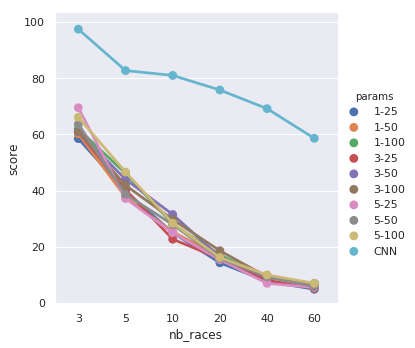

In [0]:

sns.catplot(x="nb_races", y="score", hue="params", kind="point", data=scores_data);

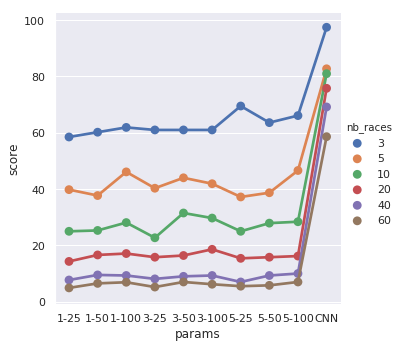

In [0]:
sns.catplot(x="params", y="score", hue="nb_races", kind="point", data=scores_data);